In [23]:
#####Poisson Tucker Decomposition####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [24]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [25]:
####データの発生####
##データの設定
type_n = 3
k1 = 12
k2 = 10
k3 = 7
hh = 10000   #ユーザー数
item = 5000   #アイテム数
context = 100   #コンテキスト数
pt = np.random.poisson(np.random.gamma(35.0, 1/0.2, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [26]:
##IDとインデックスを作成
#IDの作成
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [27]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [28]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
phi = np.random.dirichlet(np.repeat(0.25, context), topic)
theta = np.random.dirichlet(np.repeat(0.25, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(context))
context_dt = sparse.coo_matrix((np.repeat(1, hhpt), (context_id, range(hhpt))), shape=(context, hhpt)).tocsr()   #スパース行列の設定
context_n = np.array(np.sum(context_dt, axis=1)).reshape(-1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [29]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k11 = 3; k12 = 5; k13 = 5
u1 = np.array(np.random.random(hh*k11)).reshape((hh, k11))
u2 = np.zeros((hh, k12))
for j in range(k12):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k13), 1).reshape(k13), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k21 = 4; k22 = 5; k23 = 4
v1 = np.array(np.random.random(item*k21)).reshape((item, k21))
v2 = np.zeros((item, k22))
for j in range(k22):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k23), 1).reshape(k23), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [30]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    
    ##パラメータを生成
    #階層モデルの回帰係数行列を生成
    alpha_u = np.vstack((np.random.uniform(-1.6, -0.25, k1), np.random.normal(0, 0.5, k1*(col_u-1)).reshape(col_u-1, k1)))
    alpha_v = np.vstack((np.random.uniform(-1.6, -0.25, k2), np.random.normal(0, 0.5, k2*(col_v-1)).reshape(col_v-1, k2)))
    alpha_c = np.array([0.25, 0.9])
    alpha_r = np.array([0.25, 0.9])
    alpha_ut = alpha_u.copy(); alpha_vt = alpha_v.copy()

    #ガンマ分布の尺度パラメータを生成
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    #ガンマ分布の形状パラメータを生成
    beta_u = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_v = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_c = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_r = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_ut = beta_u; beta_vt = beta_v; beta_ct = beta_c; beta_rt = beta_r

    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(lambda_u, 1/beta_u)
    theta_v = np.random.gamma(lambda_v, 1/beta_v)
    theta_c = np.random.gamma(alpha_c[0], 1/alpha_c[1], context*k3).reshape(context, k3)
    omega = np.random.gamma(alpha_r[0], 1/alpha_r[1], k1*k2*k3).reshape(k1, k2, k3)
    theta_ut = theta_u.copy(); theta_vt = theta_v.copy(); theta_ct = theta_c.copy(); omegat = omega.copy()

    ##ポアソン分布から応答変数を生成
    #タッカー分解の期待値
    mu = np.repeat(0.0, hhpt)
    theta_vec2 = theta_v[item_id, ]
    theta_vec3 = theta_c[context_id, ]
    for j in range(k3):
        mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

    #応答変数を生成
    y = np.random.poisson(mu, hhpt)
    y_vec = y[:, np.newaxis]

    #break条件
    print(np.array([rp, np.max(y), np.sum(y==0)]))
    if (np.max(y) < 250) & (np.max(y) > 75) & (np.sum(y==0) > 25000) & (np.sum(y==0) < 300000):
        break

[     1    357 207603]
[     2    512 113569]
[     3    273 170968]
[     4    760 195861]
[     5    748 183775]
[     6    890 248793]
[    7  3876 36186]
[     8    448 172442]
[    9  2002 88999]
[   10  1130 94330]
[    11    704 108206]
[    12    288 244861]
[    13    308 226433]
[    14    232 341799]
[    15    505 147147]
[    16    461 226114]
[    17    175 297474]


[9464453  297474 1457843]
[5.39187679 6.77551019]
[0.67172674 0.44270817 0.50794949 0.48095352]


(array([547672., 371477., 249038., 167509., 115306.,  80148.,  56956.,
         40922.,  29795.,  22462.,  16756.,  12537.,   9450.,   7253.,
          5677.,   4349.,   3516.,   2744.,   2136.,   1756.,   1358.,
          1093.,    931.,    756.,    873.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.]),
 <a list of 25 Patch objects>)

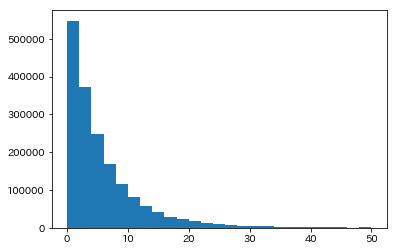

In [31]:
#生成したデータの確認
print(np.array([np.sum(y), np.sum(y==0), np.sum(y > 0)]))
print(np.array([np.mean(y), np.std(y)]))
print(np.array([np.std(theta_u), np.std(theta_v), np.std(theta_c), np.std(omega)]))
plt.hist(y, bins=25, range=(0, 50))

In [32]:
####テストデータを作成####
##テストデータのIDを作成
#欠損インデックスを設定
z = np.random.binomial(1, 0.005, hh*item*context)
index_z = np.array(np.where(z==1)[0], dtype="int")
del z

#IDを作成
user_id0 = np.repeat(range(hh), item*context)[index_z]
item_id0 = np.tile(range(item), hh*context)[index_z]
context_id0 = np.tile(range(context), hh*item)[index_z]
N = user_id0.shape[0]

##応答変数を生成
#タッカー分解の期待値
mu = np.repeat(0.0, N)
theta_vec2 = theta_v[item_id0, ]
theta_vec3 = theta_c[context_id0, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

#応答変数を生成
y0 = np.random.poisson(mu, N)
y_vec0 = y0[:, np.newaxis]

In [33]:
####マルコフ連鎖モンテカルロ法でPoisson Tucker Decompositionを推定####
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [34]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k1, k2):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k1, k2):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k1)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k2)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k1, k2): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k1, k2) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k1, k2) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [35]:
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.001
L = 3

In [36]:
##データとインデックスの設定
#定数の設定
lfactorial_y = scipy.special.gammaln(y + 1)
lfactorial_y0 = scipy.special.gammaln(y0 + 1)

#インデックスの設定
item_list = [j for j in range(item)]
context_list = [j for j in range(context)]
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")
for j in range(context):
    context_list[j] = np.array(np.where(context_id==j)[0], dtype="int")

In [37]:
##事前分布の設定
#モデルパラメータの事前分布
gamma1 = np.repeat(0, (type_n-1)*col_u)
gamma2 = np.repeat(0, (type_n-1)*col_v)
gamma3 = 1.0
tau1 = np.diag(np.repeat(100, col_u))
tau2 = np.diag(np.repeat(100, col_v))
tau_inv1 = np.linalg.inv(tau1)
tau_inv2 = np.linalg.inv(tau2)

#ガンマ分布のハイパーパラメータの設定
par = 200
delta1 = par/pt.reshape(hh, 1); delta1[delta1 < 1, ] = 1
delta2 = par/item_n.reshape(item, 1); delta2[delta2 < 1] = 1
delta3 = 1.0

In [47]:
##パラメータの真値
#階層モデルのパラメータの真値
alpha_u = alpha_ut.copy()
alpha_v = alpha_vt.copy()
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))
beta_u = beta_ut.copy()
beta_v = beta_vt.copy()
beta_c = beta_ct.copy()
beta_r = beta_rt.copy()

#行列分解のパラメータの真値
theta_u = theta_ut.copy()
theta_v = theta_vt.copy()
theta_c = theta_ct.copy()
omega = omegat.copy()

#期待値の真値
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_v[item_id, ]
theta_vec3 = theta_c[context_id, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

In [48]:
##パラメータの初期値
#階層モデルのパラメータの初期値
alpha_u = np.vstack((np.repeat(-0.5, k1), np.random.normal(0, 0.1, k1*(col_u-1)).reshape(col_u-1, k1)))
alpha_v = np.vstack((np.repeat(-0.5, k2), np.random.normal(0, 0.1, k2*(col_v-1)).reshape(col_v-1, k2)))
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))
beta_u = np.array([2.0])
beta_v = np.array([2.0])

#行列分解のパラメータの初期値
theta_u = np.random.gamma(lambda_u, 1/beta_u)
theta_v = np.random.gamma(lambda_v, 1/beta_v)
theta_c = np.random.gamma(0.1, 1/1.0, context*k3).reshape(context, k3)
omega = np.random.gamma(0.1, 1/1.0, k1*k2*k3).reshape(k1, k2, k3)

#期待値の初期値
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_v[item_id, ]
theta_vec3 = theta_c[context_id, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)

In [49]:
##サンプリング結果の格納用配列
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_C = np.zeros((context, k3, int(R/keep)))
OMEGA = np.zeros((k1, k2, k3, int(R/keep)))
ALPHA_U = np.zeros((col_u, k1, int(R/keep)))
ALPHA_V = np.zeros((col_v, k2, int(R/keep)))
BETA = np.zeros((int(R/keep), 2))

In [50]:
##学習データに対する対数尤度の基準値
#初期値での対数尤度
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_v[item_id, ]
theta_vec3 = theta_c[context_id, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LL = np.sum(y*np.log(mu) - mu - lfactorial_y)

#1パラメータモデルでの対数尤度
Lambda = np.mean(y)
LLst = np.sum(scipy.stats.poisson.logpmf(y, Lambda))

#真値での対数尤度
mu = np.repeat(0.0, hhpt)
theta_vec2 = theta_vt[item_id, ]
theta_vec3 = theta_ct[context_id, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_ut, omegat[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LLbest = np.sum(y*np.log(mu) - mu - lfactorial_y)
print(np.round(np.array([LL, LLst, LLbest]), 1))

##テストデータに対する対数尤度の基準値
#初期値での対数尤度
mu = np.repeat(0.0, N)
theta_vec2 = theta_v[item_id0, ]
theta_vec3 = theta_c[context_id0, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LL0 = np.sum(y0*np.log(mu) - mu - lfactorial_y0)

#1パラメータモデルでの対数尤度
Lambda = np.mean(y)
LLst0 = np.sum(scipy.stats.poisson.logpmf(y0, Lambda))

#テストデータに対する真値での対数尤度
mu = np.repeat(0.0, N)
theta_vec2 = theta_vt[item_id0, ]
theta_vec3 = theta_ct[context_id0, ]
for j in range(k3):
    mu += np.dot(np.dot(theta_ut, omegat[:, :, j])[user_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
LLbest0 = np.sum(y0*np.log(mu) - mu - lfactorial_y0)
print(np.round(np.array([LL0, LLst0, LLbest0]), 1))

[-28026509.2  -8115045.   -3339943.6]
[-4.28700017e+08 -1.19924185e+08 -4.83351086e+07]


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##ユーザーの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k1)); lambda_h = np.zeros((hhpt, k1))
    theta_vec1 = theta_u[user_id, ]; theta_vec2 = theta_v[item_id, ]; theta_vec3 = theta_c[context_id, ]
    for j in range(k1):
        lambda_dt = np.dot(theta_v, omega[j, :, :])[item_id, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec1[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k1)
    Lambda = mu_dt / mu[:, np.newaxis]

    #ユーザーごとのガンマ分布のパラメータ
    lambda_y = Lambda * y_vec
    W1 = np.zeros((hh, k1)); W2 = np.zeros((hh, k1))
    for i in range(hh):
        W1[i, ] = np.sum(lambda_y[user_list[i], ], axis=0)
        W2[i, ] = np.sum(lambda_h[user_list[i], ], axis=0)
    W1 = W1 + lambda_u; W2 = W2 + delta1*beta_u

    #パラメータをサンプリング
    theta_u = np.random.gamma(W1.reshape(-1), 1/W2.reshape(-1), hh*k1).reshape(hh, k1)

    ##アイテムの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k2)); lambda_h = np.zeros((hhpt, k2))
    theta_vec1 = theta_u[user_id, ]
    for j in range(k2):
        lambda_dt = np.dot(theta_u, omega[:, j, :])[user_id, ] * theta_vec3
        lambda_h[:, j] = np.dot(lambda_dt, vec_k3)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec2[:, j][:, np.newaxis], vec_k3)
    mu = np.dot(mu_dt, vec_k2)
    Lambda = mu_dt / mu[:, np.newaxis]

    #アイテムごとのガンマ分布のパラメータ
    lambda_y = Lambda * y_vec
    H1 = np.zeros((item, k2)); H2 = np.zeros((item, k2))
    for j in range(item):
        H1[j, ] = np.sum(lambda_y[item_list[j], ], axis=0)
        H2[j, ] = np.sum(lambda_h[item_list[j], ], axis=0)
    H1 = H1 + lambda_v; H2 = H2 + delta2*beta_v

    #パラメータをサンプリング
    theta_v = np.random.gamma(H1.reshape(-1), 1/H2.reshape(-1), item*k2).reshape(item, k2)

    ##コンテキストの特徴行列をサンプリング
    #補助変数lambdaを更新
    mu_dt = np.zeros((hhpt, k3)); lambda_h = np.zeros((hhpt, k3))
    theta_vec2 = theta_v[item_id, ]
    for j in range(k3):
        lambda_dt = np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2
        lambda_h[:, j] = np.dot(lambda_dt, vec_k2)
        mu_dt[:, j] = np.dot(lambda_dt * theta_vec3[:, j][:, np.newaxis], vec_k2)
    mu = np.dot(mu_dt, vec_k3)
    Lambda = mu_dt / mu[:, np.newaxis]

    #コンテキストごとのガンマ分布のパラメータ
    lambda_y = Lambda * y_vec
    C1 = np.zeros((context, k3)); C2 = np.zeros((context, k3))
    for j in range(context):
        C1[j, ] = np.sum(lambda_y[context_list[j], ], axis=0)
        C2[j, ] = np.sum(lambda_h[context_list[j], ], axis=0)
    C1 = C1 + gamma3; C2 = C2 + delta3

    #パラメータをサンプリング
    theta_c = np.random.gamma(C1.reshape(-1), 1/C2.reshape(-1), context*k3).reshape(context, k3)

    ##ガンマ分布よりomegaをサンプリング
    #補助変数lambdaを更新
    mu_block = np.zeros((k1, k2, k3))
    theta_dt12 = [j for j in range(k1)]
    for j1 in range(k3):
        theta_dt3 = theta_vec3[:, j1][:, np.newaxis]
        for j2 in range(k1):
            if j1==0:
                theta_dt12[j2] = theta_vec1[:, j2][:, np.newaxis] * theta_vec2
            mu_dt = theta_dt12[j2] * theta_dt3
            mu_block[j2, :, j1] = np.sum(mu_dt, axis=0)
    omega_block = omega * mu_block
    Lambda = omega_block / np.sum(omega_block)

    #ガンマ分布からパラメータをサンプリング
    omega1 = Lambda * np.sum(y) + gamma3
    omega2 = mu_block + delta3
    omega = np.random.gamma(omega1, 1/omega2)


    ##階層モデルのパラメータをサンプリング
    #採択率の格納用ベクトル
    accept_prob_u = np.repeat(0.0, k1)
    accept_prob_v = np.repeat(0.0, k2)

    ##ユーザー特徴行列の尺度パラメータをサンプリング
    for j in range(k1):
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_u)
        alphad = alpha_u[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_u[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_u, tau_inv1, d, d_log, u, hh)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_u[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_u[:, j] = alphan
        else:
            alpha_u[:, j] = alphad

    ##アイテム特徴行列の尺度パラメータをサンプリング
    for j in range(k2):
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_v)
        alphad = alpha_v[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_v[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_v, tau_inv2, d, d_log, v, item)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_v[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_v[:, j] = alphan
        else:
            alpha_v[:, j] = alphad

    #lambdaを更新
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))
    
    ##尺度パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, 2)
    betad = np.append(beta_u, beta_v)

    #リープフロッグ法による1ステップ移動
    d1 = theta_u.reshape(-1); d2 = theta_v.reshape(-1)
    res = leapfrog_beta(rold, betad, dloglike_beta, e2, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k1, k2)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    d_log1 = np.log(d1); d_log2 = np.log(d2)
    Hnew = -loglike_beta(betan, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k1, k2) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike_beta(betad, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k1, k2) + np.sum(np.power(rold, 2)) / 2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
    accept_prob_a = accept_prob

    #採択率に基づきgammaを採択
    if(accept_prob >= rand):
        beta = betan
        beta_u = beta[0]; beta_v = beta[1]
    else:
        beta = betad
        beta_u = beta[0]; beta_v = beta[1]


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_C[:, :, mkeep] = theta_c
        OMEGA[:, :, :, mkeep] = omega
        ALPHA_U[:, :, mkeep] = alpha_u
        ALPHA_V[:, :, mkeep] = alpha_v
        BETA[mkeep, ] = np.append(beta_u, beta_v)
        
    if rp%disp==0:
        #学習データに対する対数尤度
        mu = np.repeat(0.0, hhpt)
        theta_vec2 = theta_v[item_id, ]
        theta_vec3 = theta_c[context_id, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL = np.sum(y*np.log(mu) - mu - lfactorial_y)

        #テストデータに対する対数尤度
        mu = np.repeat(0.0, N)
        theta_vec2 = theta_v[item_id0, ]
        theta_vec3 = theta_c[context_id0, ]
        for j in range(k3):
            mu += np.dot(np.dot(theta_u, omega[:, :, j])[user_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
        LL0 = np.sum(y0*np.log(mu) - mu - lfactorial_y0)

        #サンプリング結果を表示
        print(rp)
        print([np.round(LL, 1), np.round(LLst, 1), np.round(LLbest, 1)])
        print([np.round(LL0, 1), np.round(LLst0, 1), np.round(LLbest0, 1)])
        print(np.round(accept_prob_u, 3))
        print(np.round(accept_prob_v, 3))
        print(np.round(np.array([beta_u, beta_v]), 3))

0
[-4320905.0, -8115045.0, -3339943.6]
[-67645463.4, -119924184.7, -48335108.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.46  1.794]
10
[-3593935.3, -8115045.0, -3339943.6]
[-54066329.6, -119924184.7, -48335108.6]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.998 1.    1.   ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.29 0.88]
20
[-3541610.4, -8115045.0, -3339943.6]
[-53377182.9, -119924184.7, -48335108.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.997]
[1.72  0.835]
30
[-3523138.5, -8115045.0, -3339943.6]
[-53221099.1, -119924184.7, -48335108.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.94  0.875]
40
[-3512928.3, -8115045.0, -3339943.6]
[-53210704.8, -119924184.7, -48335108.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.978 0.929]
50
[-3505830.8, -8115045.0, -3339943.6]
[-53216458.0, -119924184.7, -48335108.6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

380
[-3440150.0, -8115045.0, -3339943.6]
[-53467680.1, -119924184.7, -48335108.6]
[0.997 1.    1.    1.    1.    0.999 1.    1.    0.997 0.998 1.    1.   ]
[0.999 1.    0.998 1.    1.    0.999 1.    1.    1.    1.   ]
[0.778 1.11 ]
390
[-3439032.4, -8115045.0, -3339943.6]
[-53446807.4, -119924184.7, -48335108.6]
[1.    1.    0.997 1.    1.    1.    1.    1.    1.    1.    0.998 1.   ]
[1.    1.    1.    0.999 0.999 1.    1.    0.998 0.999 1.   ]
[0.772 1.099]
400
[-3438398.5, -8115045.0, -3339943.6]
[-53449527.9, -119924184.7, -48335108.6]
[1.    1.    0.999 1.    1.    1.    0.999 0.999 1.    1.    1.    1.   ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.774 1.076]
410
[-3437408.2, -8115045.0, -3339943.6]
[-53435954.0, -119924184.7, -48335108.6]
[1.    0.999 1.    0.999 1.    1.    0.998 1.    1.    1.    1.    0.998]
[1.    1.    1.    1.    1.    1.    0.998 0.998 1.    0.998]
[0.767 1.065]
420
[-3436364.2, -8115045.0, -3339943.6]
[-53405871.8, -119924184.7, -48335108.6]
[0.999 1.    1.    0

740
[-3419678.7, -8115045.0, -3339943.6]
[-53059505.0, -119924184.7, -48335108.6]
[0.998 0.999 0.999 1.    0.996 1.    1.    1.    0.997 1.    0.997 1.   ]
[1.    1.    1.    1.    0.999 1.    1.    1.    1.    0.999]
[0.797 0.887]
750
[-3419539.4, -8115045.0, -3339943.6]
[-53026929.1, -119924184.7, -48335108.6]
[0.999 1.    1.    1.    1.    0.999 1.    0.996 1.    1.    1.    1.   ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.798 0.881]
760
[-3419245.0, -8115045.0, -3339943.6]
[-53028489.4, -119924184.7, -48335108.6]
[0.998 1.    0.998 1.    0.999 1.    1.    1.    1.    1.    1.    1.   ]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.998]
[0.8   0.888]
770
[-3418647.4, -8115045.0, -3339943.6]
[-53024799.1, -119924184.7, -48335108.6]
[1.    1.    0.996 1.    0.998 1.    1.    0.999 1.    0.999 0.999 1.   ]
[0.998 0.999 1.    1.    1.    1.    0.999 1.    1.    1.   ]
[0.802 0.882]
780
[-3418206.4, -8115045.0, -3339943.6]
[-53010071.6, -119924184.7, -48335108.6]
[1.    0.997 1.    0

1100
[-3411641.5, -8115045.0, -3339943.6]
[-52698785.6, -119924184.7, -48335108.6]
[1.    1.    1.    1.    1.    1.    0.998 1.    1.    1.    0.999 0.999]
[0.998 0.996 1.    1.    1.    0.998 0.999 1.    1.    1.   ]
[0.82 0.85]
1110
[-3411779.8, -8115045.0, -3339943.6]
[-52680421.4, -119924184.7, -48335108.6]
[1.    0.998 1.    1.    0.998 1.    0.998 1.    1.    1.    1.    1.   ]
[0.999 0.998 0.999 1.    0.994 1.    1.    0.999 1.    1.   ]
[0.813 0.857]
1120
[-3411209.0, -8115045.0, -3339943.6]
[-52676062.5, -119924184.7, -48335108.6]
[1.    1.    1.    1.    0.998 1.    0.981 1.    1.    1.    0.999 0.999]
[0.998 0.999 1.    1.    1.    1.    1.    0.999 1.    0.999]
[0.822 0.861]
1130
[-3411211.8, -8115045.0, -3339943.6]
[-52665326.9, -119924184.7, -48335108.6]
[0.991 0.998 0.993 0.999 0.995 1.    1.    1.    0.995 1.    1.    1.   ]
[1.    1.    0.999 1.    0.999 1.    1.    0.997 1.    1.   ]
[0.821 0.862]
1140
[-3411174.5, -8115045.0, -3339943.6]
[-52652384.0, -119924184.7, 